**WEEK - 4**

**Step 1.Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**HYPERPARAMETERS**

In [3]:
# ------------------- IMPORTS -------------------
import os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ------------------- HYPERPARAMETERS -------------------
HYPERPARAMS = {
    "img_height": 256,
    "img_width": 256,
    "batch_size": 16,        # increased
    "epochs": 30,            # increased
    "limit": 400,
    "seed": 42,
    "learning_rate": 1e-4,
    "optimizer": "Adam",
    "dropout_rate": 0.5
}

IMG_H, IMG_W = HYPERPARAMS["img_height"], HYPERPARAMS["img_width"]
BATCH_SIZE   = HYPERPARAMS["batch_size"]
EPOCHS       = HYPERPARAMS["epochs"]
LIMIT        = HYPERPARAMS["limit"]
SEED         = HYPERPARAMS["seed"]

# ------------------- PATHS -------------------
IMAGE_DIR = "/content/drive/MyDrive/VisionExtract/data/coco2017/original_images"
MASK_DIR  = "/content/drive/MyDrive/VisionExtract/data/coco2017/train_masks"

# ------------------- PAIRING IMAGES AND MASKS -------------------
def get_pairs(img_dir, mask_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_set = set(mask_files)
    pairs = []
    for img in img_files:
        stem = os.path.splitext(img)[0]
        expected_mask = stem + "_mask.png"
        if expected_mask in mask_set:
            pairs.append((os.path.join(img_dir, img), os.path.join(mask_dir, expected_mask)))
    return pairs

pairs = get_pairs(IMAGE_DIR, MASK_DIR)
print("Total pairs found:", len(pairs))
if len(pairs) == 0:
    raise RuntimeError("No image-mask pairs found. Check file names (_mask.png).")

if LIMIT:
    pairs = pairs[:LIMIT]

random.seed(SEED)
random.shuffle(pairs)

# ------------------- LOADING DATA -------------------
def load_pairs_to_numpy(pairs, img_h=IMG_H, img_w=IMG_W):
    X, Y = [], []
    for img_path, mask_path in pairs:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w, img_h))
        img = preprocess_input(img.astype(np.float32))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)
        mask = mask[..., np.newaxis]

        X.append(img)
        Y.append(mask.astype(np.float32))
    return np.stack(X, axis=0), np.stack(Y, axis=0)

X_train, y_train = load_pairs_to_numpy(pairs)
print("Loaded X_train:", X_train.shape, "y_train:", y_train.shape)

# ------------------- LOSS + METRICS -------------------
def dice_coef_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss_tf(y_true, y_pred):
    return 1.0 - dice_coef_tf(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()
def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss_tf(y_true, y_pred)

class PixelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='pixel_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
        y_true_f = tf.cast(y_true, tf.float32)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_bin), tf.float32))
        total = tf.cast(tf.size(y_true_f), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)
    def result(self):
        return self.correct / (self.total + 1e-8)
    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# ------------------- BUILD U-NET -------------------
def build_unet_resnet50(input_shape=(IMG_H, IMG_W, 3), backbone_trainable=False, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    backbone.trainable = backbone_trainable

    c1 = backbone.get_layer("conv1_relu").output
    c2 = backbone.get_layer("conv2_block3_out").output
    c3 = backbone.get_layer("conv3_block4_out").output
    c4 = backbone.get_layer("conv4_block6_out").output
    c5 = backbone.get_layer("conv5_block3_out").output

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D(size=(2,2))(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    d4 = decoder_block(c5, c4, 512)
    d3 = decoder_block(d4, c3, 256)
    d2 = decoder_block(d3, c2, 128)
    d1 = decoder_block(d2, c1, 64)

    x = layers.UpSampling2D(size=(2,2))(d1)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

# ------------------- OPTIMIZER -------------------
if HYPERPARAMS["optimizer"] == "Adam":
    optimizer = Adam(learning_rate=HYPERPARAMS["learning_rate"])
elif HYPERPARAMS["optimizer"] == "SGD":
    optimizer = SGD(learning_rate=HYPERPARAMS["learning_rate"], momentum=0.9)
elif HYPERPARAMS["optimizer"] == "RMSprop":
    optimizer = RMSprop(learning_rate=HYPERPARAMS["learning_rate"])

# ------------------- MODEL -------------------
model = build_unet_resnet50(
    input_shape=(IMG_H, IMG_W, 3),
    backbone_trainable=False,
    dropout_rate=HYPERPARAMS["dropout_rate"]
)
model.compile(optimizer=optimizer, loss=bce_dice_loss,
              metrics=[PixelAccuracy(), MeanIoU(num_classes=2)])
model.summary()

# ------------------- CALLBACKS -------------------
callbacks = [
    EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("unet_resnet50_best.h5", monitor="loss", save_best_only=True, verbose=1)
]

# ------------------- TRAINING -------------------
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=callbacks
)


Total pairs found: 157
Loaded X_train: (157, 256, 256, 3) y_train: (157, 256, 256, 1)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 47,128,385 (179.78 MB)

 Trainable params: 23,540,673 (89.80 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.6701 - mean_io_u: 0.3842 - pixel_accuracy: 0.4768   
Epoch 1: loss improved from inf to 1.51750, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 120s 6s/step - loss: 1.6562 - mean_io_u: 0.3835 - pixel_accuracy: 0.4853 - learning_rate: 1.0000e-04
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 1.2406 - mean_io_u: 0.3788 - pixel_accuracy: 0.7118
Epoch 2: loss improved from 1.51750 to 1.15439, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - loss: 1.2328 - mean_io_u: 0.3786 - pixel_accuracy: 0.7129 - learning_rate: 1.0000e-04
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 0.9195 - mean_io_u: 0.3682 - pixel_accuracy: 0.7733
Epoch 3: loss improved from 1.15439 to 0.89922, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 569ms/step - loss: 0.9176 - mean_io_u: 0.3689 - pixel_accuracy: 0.7741 - learning_rate: 1.0000e-04
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.6498 - mean_io_u: 0.3725 - pixel_accuracy: 0.8659
Epoch 4: loss improved from 0.89922 to 0.60353, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - loss: 0.6456 - mean_io_u: 0.3728 - pixel_accuracy: 0.8673 - learning_rate: 1.0000e-04
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.5131 - mean_io_u: 0.3840 - pixel_accuracy: 0.9101
Epoch 5: loss improved from 0.60353 to 0.50040, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - loss: 0.5119 - mean_io_u: 0.3833 - pixel_accuracy: 0.9099 - learning_rate: 1.0000e-04
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 0.4117 - mean_io_u: 0.3739 - pixel_accuracy: 0.9254
Epoch 6: loss improved from 0.50040 to 0.40607, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - loss: 0.4112 - mean_io_u: 0.3741 - pixel_accuracy: 0.9256 - learning_rate: 1.0000e-04
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.3907 - mean_io_u: 0.3821 - pixel_accuracy: 0.9243
Epoch 7: loss improved from 0.40607 to 0.36329, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - loss: 0.3882 - mean_io_u: 0.3815 - pixel_accuracy: 0.9250 - learning_rate: 1.0000e-04
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.2842 - mean_io_u: 0.3839 - pixel_accuracy: 0.9487
Epoch 8: loss improved from 0.36329 to 0.28557, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 619ms/step - loss: 0.2843 - mean_io_u: 0.3833 - pixel_accuracy: 0.9486 - learning_rate: 1.0000e-04
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 0.2635 - mean_io_u: 0.3696 - pixel_accuracy: 0.9513
Epoch 9: loss improved from 0.28557 to 0.25644, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - loss: 0.2629 - mean_io_u: 0.3702 - pixel_accuracy: 0.9515 - learning_rate: 1.0000e-04
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - loss: 0.2149 - mean_io_u: 0.3768 - pixel_accuracy: 0.9587
Epoch 10: loss improved from 0.25644 to 0.21776, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - loss: 0.2152 - mean_io_u: 0.3772 - pixel_accuracy: 0.9587 - learning_rate: 1.0000e-04
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.2002 - mean_io_u: 0.3639 - pixel_accuracy: 0.9603
Epoch 11: loss improved from 0.21776 to 0.20019, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step - loss: 0.2002 - mean_io_u: 0.3657 - pixel_accuracy: 0.9606 - learning_rate: 1.0000e-04
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.1929 - mean_io_u: 0.3787 - pixel_accuracy: 0.9628
Epoch 12: loss improved from 0.20019 to 0.18710, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - loss: 0.1924 - mean_io_u: 0.3797 - pixel_accuracy: 0.9630 - learning_rate: 1.0000e-04
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.1595 - mean_io_u: 0.3722 - pixel_accuracy: 0.9692
Epoch 13: loss improved from 0.18710 to 0.16016, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 831ms/step - loss: 0.1596 - mean_io_u: 0.3731 - pixel_accuracy: 0.9693 - learning_rate: 1.0000e-04
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 0.1358 - mean_io_u: 0.3996 - pixel_accuracy: 0.9749
Epoch 14: loss improved from 0.16016 to 0.14259, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - loss: 0.1365 - mean_io_u: 0.3994 - pixel_accuracy: 0.9747 - learning_rate: 1.0000e-04
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 0.1269 - mean_io_u: 0.3920 - pixel_accuracy: 0.9766
Epoch 15: loss improved from 0.14259 to 0.12722, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step - loss: 0.1269 - mean_io_u: 0.3926 - pixel_accuracy: 0.9766 - learning_rate: 1.0000e-04
Epoch 16/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 0.1125 - mean_io_u: 0.4311 - pixel_accuracy: 0.9791
Epoch 16: loss improved from 0.12722 to 0.11465, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 548ms/step - loss: 0.1127 - mean_io_u: 0.4306 - pixel_accuracy: 0.9790 - learning_rate: 1.0000e-04
Epoch 17/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 0.1037 - mean_io_u: 0.4170 - pixel_accuracy: 0.9802
Epoch 17: loss improved from 0.11465 to 0.10768, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - loss: 0.1040 - mean_io_u: 0.4183 - pixel_accuracy: 0.9802 - learning_rate: 1.0000e-04
Epoch 18/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.0970 - mean_io_u: 0.4608 - pixel_accuracy: 0.9819
Epoch 18: loss improved from 0.10768 to 0.09802, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 700ms/step - loss: 0.0971 - mean_io_u: 0.4596 - pixel_accuracy: 0.9819 - learning_rate: 1.0000e-04
Epoch 19/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0901 - mean_io_u: 0.4538 - pixel_accuracy: 0.9834
Epoch 19: loss improved from 0.09802 to 0.09098, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 569ms/step - loss: 0.0902 - mean_io_u: 0.4544 - pixel_accuracy: 0.9833 - learning_rate: 1.0000e-04
Epoch 20/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.0818 - mean_io_u: 0.4594 - pixel_accuracy: 0.9842
Epoch 20: loss improved from 0.09098 to 0.08736, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 576ms/step - loss: 0.0823 - mean_io_u: 0.4587 - pixel_accuracy: 0.9841 - learning_rate: 1.0000e-04
Epoch 21/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.0898 - mean_io_u: 0.4608 - pixel_accuracy: 0.9828
Epoch 21: loss did not improve from 0.08736
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - loss: 0.0897 - mean_io_u: 0.4606 - pixel_accuracy: 0.9828 - learning_rate: 1.0000e-04
Epoch 22/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.0881 - mean_io_u: 0.4511 - pixel_accuracy: 0.9837
Epoch 22: loss did not improve from 0.08736
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - loss: 0.0881 - mean_io_u: 0.4518 - pixel_accuracy: 0.9836 - learning_rate: 1.0000e-04
Epoch 23/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.0952 - mean_io_u: 0.4530 - pixel_accuracy: 0.9807
Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 23: loss did not improve from 0.08736
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - loss: 0.0949 - mean_

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0786 - mean_io_u: 0.4889 - pixel_accuracy: 0.9857 - learning_rate: 5.0000e-05
Epoch 26/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.0742 - mean_io_u: 0.5240 - pixel_accuracy: 0.9859
Epoch 26: loss improved from 0.07756 to 0.07499, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 879ms/step - loss: 0.0742 - mean_io_u: 0.5225 - pixel_accuracy: 0.9859 - learning_rate: 5.0000e-05
Epoch 27/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.0691 - mean_io_u: 0.5009 - pixel_accuracy: 0.9864
Epoch 27: loss improved from 0.07499 to 0.07135, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.0693 - mean_io_u: 0.5016 - pixel_accuracy: 0.9864 - learning_rate: 5.0000e-05
Epoch 28/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.0754 - mean_io_u: 0.5137 - pixel_accuracy: 0.9857
Epoch 28: loss improved from 0.07135 to 0.06902, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 578ms/step - loss: 0.0748 - mean_io_u: 0.5139 - pixel_accuracy: 0.9858 - learning_rate: 5.0000e-05
Epoch 29/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0696 - mean_io_u: 0.5160 - pixel_accuracy: 0.9878
Epoch 29: loss improved from 0.06902 to 0.06706, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 562ms/step - loss: 0.0694 - mean_io_u: 0.5165 - pixel_accuracy: 0.9877 - learning_rate: 5.0000e-05
Epoch 30/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.0618 - mean_io_u: 0.5471 - pixel_accuracy: 0.9884
Epoch 30: loss improved from 0.06706 to 0.06299, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.0619 - mean_io_u: 0.5470 - pixel_accuracy: 0.9884 - learning_rate: 5.0000e-05


**Step 1:Load your dataset**

In [24]:
import os, random
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

IMAGE_DIR = "/content/drive/MyDrive/VisionExtract/data/coco2017/original_images"
MASK_DIR  = "/content/drive/MyDrive/VisionExtract/data/coco2017/train_masks"
IMG_H, IMG_W = 256, 256
SEED = 42
LIMIT = 400

# Pair images with masks
def get_pairs(img_dir, mask_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_set = set(mask_files)
    pairs = []
    for img in img_files:
        stem = os.path.splitext(img)[0]
        expected_mask = stem + "_mask.png"
        if expected_mask in mask_set:
            pairs.append((os.path.join(img_dir, img), os.path.join(mask_dir, expected_mask)))
    return pairs

pairs = get_pairs(IMAGE_DIR, MASK_DIR)
if LIMIT:
    pairs = pairs[:LIMIT]

random.seed(SEED)
random.shuffle(pairs)

# Load images and masks
def load_pairs_to_numpy(pairs, img_h=IMG_H, img_w=IMG_W):
    X, Y = [], []
    for img_path, mask_path in pairs:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w, img_h))
        img = preprocess_input(img.astype(np.float32))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)
        mask = mask[..., np.newaxis]

        X.append(img)
        Y.append(mask.astype(np.float32))
    return np.stack(X, axis=0), np.stack(Y, axis=0)

X_train, y_train = load_pairs_to_numpy(pairs)
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)


X_train shape: (157, 256, 256, 3) y_train shape: (157, 256, 256, 1)


**Step 2:Rebuild your U-Net model**

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50

# Define Dice + BCE loss and PixelAccuracy metric (same as before)
def dice_coef_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss_tf(y_true, y_pred):
    return 1.0 - dice_coef_tf(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()
def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss_tf(y_true, y_pred)

class PixelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='pixel_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
        y_true_f = tf.cast(y_true, tf.float32)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_bin), tf.float32))
        total = tf.cast(tf.size(y_true_f), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)
    def result(self):
        return self.correct / (self.total + 1e-8)
    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# Build U-Net with ResNet50 backbone
def build_unet_resnet50(input_shape=(IMG_H, IMG_W, 3), backbone_trainable=False, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    backbone.trainable = backbone_trainable

    c1 = backbone.get_layer("conv1_relu").output
    c2 = backbone.get_layer("conv2_block3_out").output
    c3 = backbone.get_layer("conv3_block4_out").output
    c4 = backbone.get_layer("conv4_block6_out").output
    c5 = backbone.get_layer("conv5_block3_out").output

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D(size=(2,2))(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    d4 = decoder_block(c5, c4, 512)
    d3 = decoder_block(d4, c3, 256)
    d2 = decoder_block(d3, c2, 128)
    d1 = decoder_block(d2, c1, 64)

    x = layers.UpSampling2D(size=(2,2))(d1)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

# Compile model
optimizer = Adam(learning_rate=1e-4)
model = build_unet_resnet50()
model.compile(optimizer=optimizer, loss=bce_dice_loss,
              metrics=[PixelAccuracy(), MeanIoU(num_classes=2)])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 47,128,385 (179.78 MB)

 Trainable params: 23,540,673 (89.80 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Step 3:Load your saved model**

In [26]:
from tensorflow.keras.models import load_model

# If you saved using ModelCheckpoint("unet_resnet50_best.keras")
model = load_model("/content/drive/MyDrive/VisionExtract/unet_resnet50_best.keras",
                   custom_objects={'bce_dice_loss': bce_dice_loss, 'PixelAccuracy': PixelAccuracy})


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


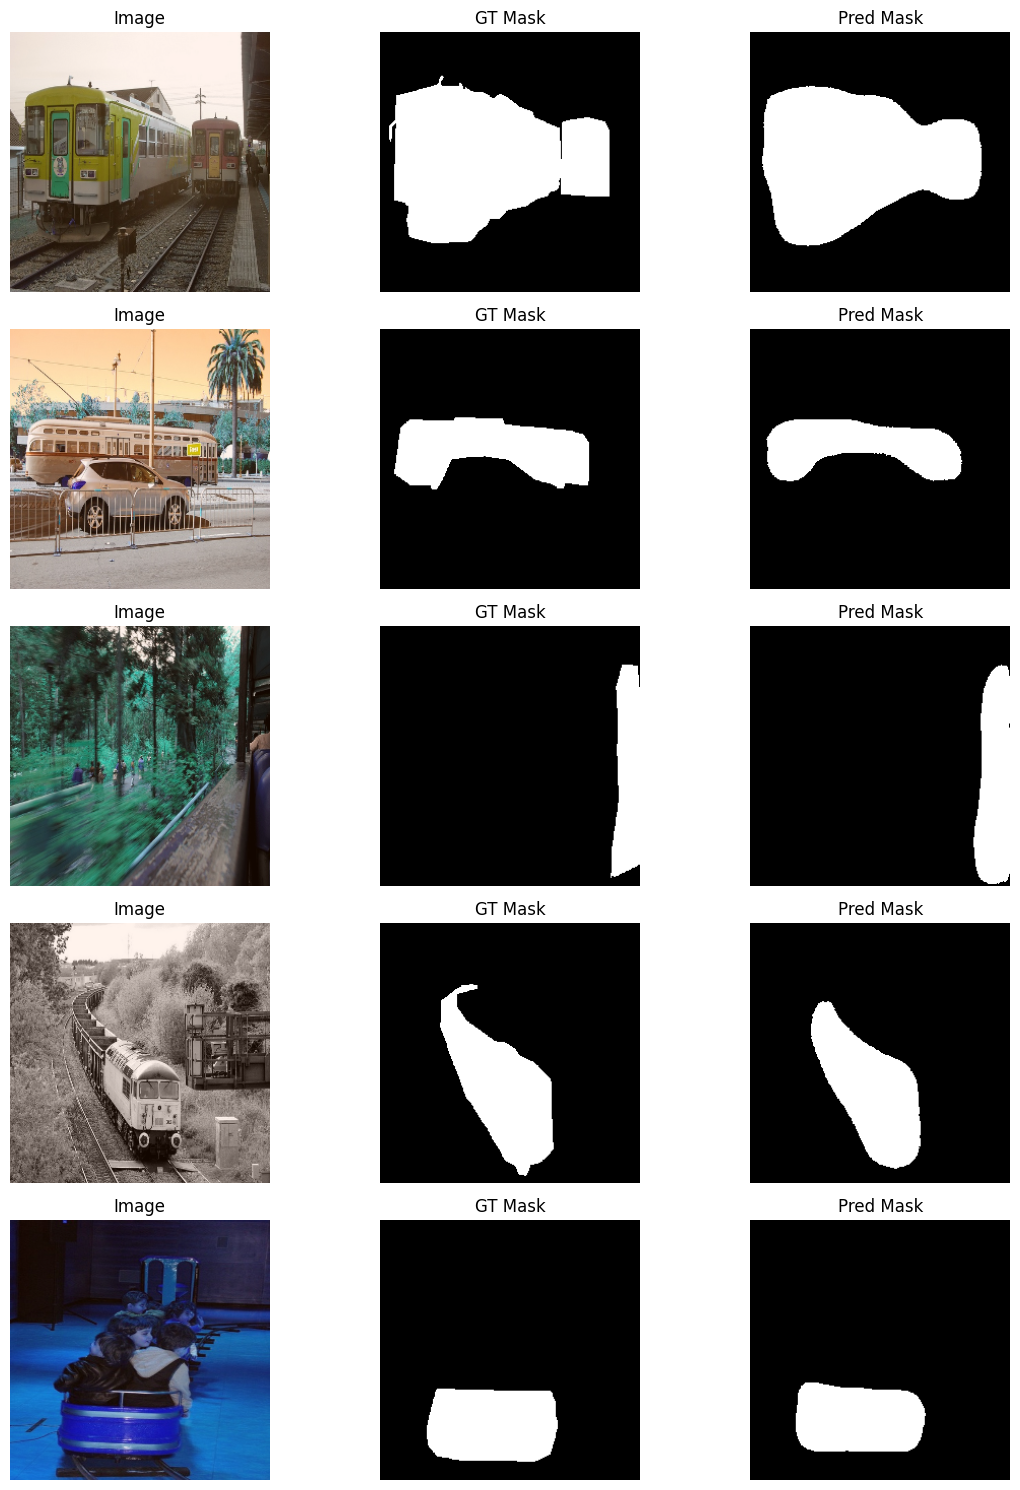

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to show
num_show = min(5, X_train.shape[0])
indices = np.random.choice(X_train.shape[0], num_show, replace=False)

# Get predictions
preds = model.predict(X_train[indices])
pred_bins = (preds > 0.5).astype(np.uint8)  # convert to binary masks

plt.figure(figsize=(12, num_show*3))

for i, idx in enumerate(indices):
    # Original image for display
    img_disp = X_train[idx].copy()
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)  # scale to 0..1

    # Plot original image
    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(img_disp)
    plt.title("Image")
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(y_train[idx].squeeze(), cmap='gray')
    plt.title("GT Mask")
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(pred_bins[i].squeeze(), cmap='gray')
    plt.title("Pred Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()
